## Part 1 Explatoratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns   

In [2]:
login_df = pd.read_json('logins.json')
login_df.columns

Index(['login_time'], dtype='object')

In [3]:
login_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
login_df['login_time'] = pd.to_datetime(login_df['login_time']) 
login_df.set_index('login_time', inplace=True)

In [5]:
login_df.head()

""
login_time
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:37
1970-01-01 20:16:36
1970-01-01 20:26:21


In [6]:
login_counts = login_df.resample('15min').size().to_frame(name='login_count')
login_counts.head()

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [7]:
login_counts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15min
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   login_count  9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


The date format range seems to be valid no outlier dates such as 2099

In [8]:
missing_check = login_counts.asfreq('15min')  # Fill missing intervals with NaNs
print("Missing timestamps:", missing_check.isnull().sum().values[0])

Missing timestamps: 0


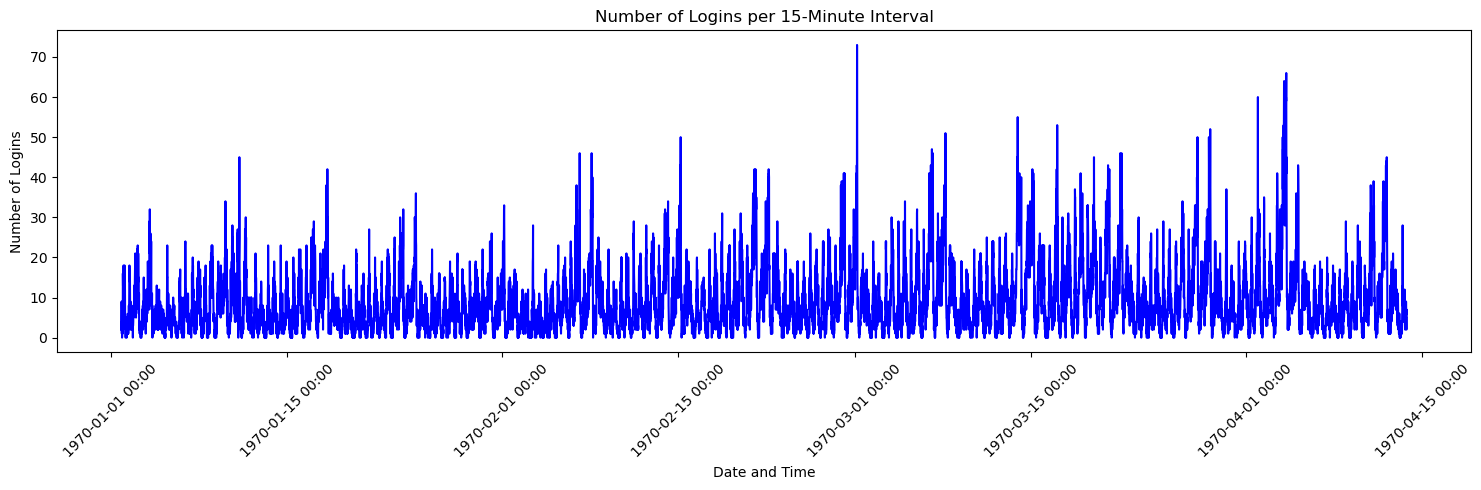

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(login_counts, color='blue')
plt.title('Number of Logins per 15-Minute Interval')
plt.xlabel('Date and Time')
plt.ylabel('Number of Logins')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

The time series plot shows that the number of logins per 15-minute interval ranges from 0 (least) to over 70 (most). The highest login activity occurs around early March 1970 at midnight, while many intervals have very few or no logins, there are strong fluctuations in user demand over time.

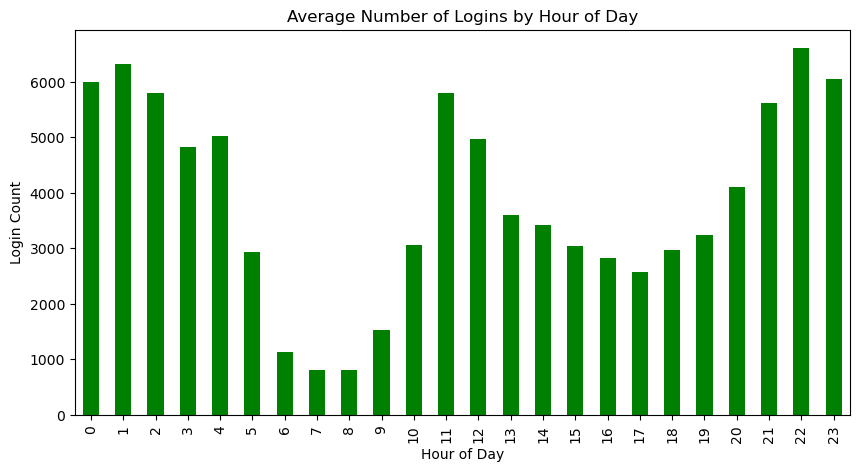

In [10]:
login_df['hour'] = login_df.index.hour
hourly_avg = login_df.groupby('hour').size()

plt.figure(figsize=(10, 5))
hourly_avg.plot(kind='bar', color='green')
plt.title('Average Number of Logins by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Login Count')
plt.show()

The most frequent hour login seems be 22 which is 10pm in 12 hour format, and the least seems to be 7-8 am showing around this time majority of the users are likely sleeping or getting ready for work and then logins rise around 11-12pm which is during lunch. Overall activity builds up in the morning dips midday and rises in the evening, a classic daily cycle.

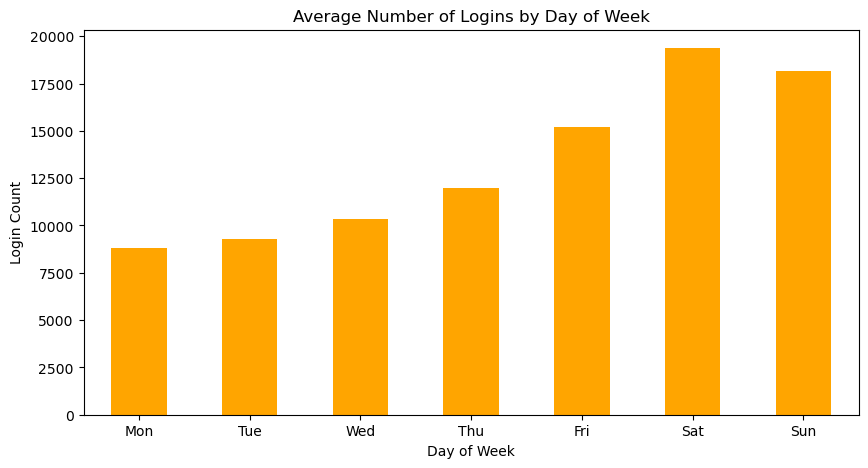

In [11]:
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Calculate average number of logins by day of week
day_avg = login_df.groupby(login_df.index.dayofweek).size()

plt.figure(figsize=(10, 5))
day_avg.plot(kind='bar', color='orange')
plt.title('Average Number of Logins by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Login Count')
plt.xticks(ticks=range(len(day_names)), labels=day_names, rotation=0)
plt.show()


In the day EDA, we can conclude that indeed that the platform for user login peaks on the weekend, the user activity starts to rise by Friday and peaks by Saturday then steadily falls of by Sunday. Then on the weekdays the platform is at its lowest then slowly cycles back.

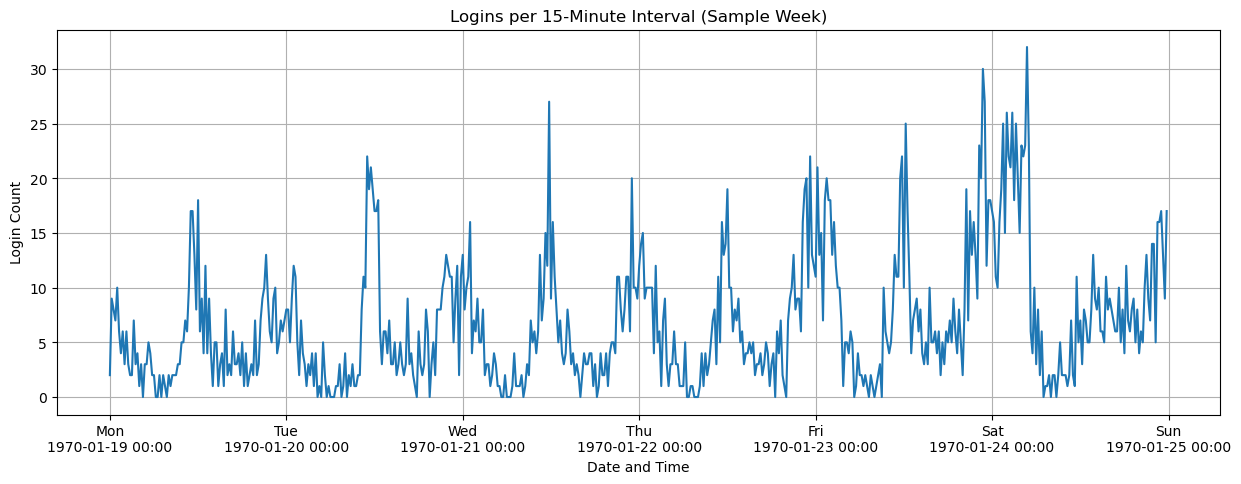

In [12]:
sample_week = login_counts['1970-01-19':'1970-01-24']

plt.figure(figsize=(15, 5))
plt.plot(sample_week)
plt.title('Logins per 15-Minute Interval (Sample Week)')
plt.xlabel('Date and Time')
plt.ylabel('Login Count')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a\n%Y-%m-%d %H:%M'))
plt.grid(True)
plt.show()


This sample week proves that the platform is indeed consistent with the logins being the lowest during the weekdays and peaking around the weekends. The timestamp also proves that the platform login is highest during midnight and drops as later into morning.

## Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

#### 1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
- Assuming the main goal for Ultimate is to maximize revenue by reimbursing the toll cost so that more drivers are working in both cities rather than sticking to one. The main metric to clearly see if the incentive of toll reimbursement is working is to directly measure the number of drivers crossing the bridge between Gotham and Metropolis per week after the incentive was initiated. If we see a clear indication that the number of drivers is increasing, that would mean the toll was the main reason for Ultimate drivers staying local to one city. This toll reimbursement would also allow for equilibrium much quicker for example if Metropolis is too busy then drivers wouldn't hesitate to leave to the other city, this new metric of measuring the time for reaching equilibrium would show.

#### 2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a) how you will implement the experiment?
The main and most effective way to compare the effectiveness of the toll change would be to run an A/B test.
- Group A: The control group pays where the driver pays the toll as usual.
- Group B: The treatment group where the driver gets the toll reimbursed.

The goal of the experiment is to compare which group of drivers crosses the bridge more often during the same hours of the day. If the group that gets the toll paid for them crosses significantly more, then we can say the toll reimbursement likely caused the increase.

b) what statistical test(s) you will conduct to verify the significance of the
observation?

Use the two-proportion z-test
- Null hypothesis (H₀): There is no difference. The percentage of drivers who cross is the same in both groups.
- Alternative hypothesis (H₁): The treatment group (Group B) has a higher percentage of bridge crossings, the toll is working

Count the number of times drivers crossed the bridge in each group. If the toll has no effect, what is the chance that we will see this difference in bridge crossing just by chance? If we get a p-value of < 0.05, that means it's not due to just random chance but rather the tool is making a difference, so we would reject the null hypothesis.  

c) how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

- If the crossing did increase significantly, this would show that the incentive is effective in a positive way and that the change should be implemented.
- If there was no noticeable difference, the company would need to start considering other incentives for drivers for cross-exploration in both cities, such as bonus pay or promising a certain number of guaranteed trips.

In some way, there would be some data analysis that is done before assessing whether the new change should be made or not. This is a question that can only be answered with real data tests. The caveats could be that it takes time for drivers to adjust to this new change compared to their old earning style. Gas, traffic, or other reasons might prevent people from making long trips. Are the drivers getting rides in the other city? Are they helping to reduce the wait time for customers?


## Part 3 Predictive Modelling

#### Question 1: Mainly asking about Explatoratory Data Analysis (EDA) and Data Wrangling

In [13]:
ultimate_df = pd.read_json('ultimate_data_challenge.json')
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [14]:
print(ultimate_df.shape)
print(ultimate_df.info())
print(ultimate_df.describe())

(50000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
None
       trips_in_first_30_days  avg_rating_of_driver     avg_s

In [15]:
ultimate_df['signup_date'].dtype
# Convert signup_date to datetime
ultimate_df['signup_date'] = pd.to_datetime(ultimate_df['last_trip_date'])
ultimate_df['signup_date'].dtype

dtype('<M8[ns]')

In [16]:
ultimate_df['last_trip_date'].dtype
# Convert last_trip_date to datetime
ultimate_df['last_trip_date'] = pd.to_datetime(ultimate_df['last_trip_date'])
ultimate_df['last_trip_date'].dtype

dtype('<M8[ns]')

In [17]:
ultimate_df['last_trip_date'].max()

Timestamp('2014-07-01 00:00:00')

#### Decide a user is still active by seeing if the user are still active 30 days preceding the dataset was pulled in July 1st. If a user took a trip within June 1st to July 1st they are still using the app this means that the user engagement with the platform is still active, if not they likely churned.

In [18]:
cutoff_date = dt.datetime(2014, 6, 1)
ultimate_df['active'] = ultimate_df['last_trip_date'] >= cutoff_date
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-06-17,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-05-05,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-07,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-06-29,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-03-15,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


In [19]:
active_users = ultimate_df[ultimate_df['active'] == True]
inactive_users = ultimate_df[ultimate_df['active'] == False]
print(f"Active users: {len(active_users)}")
print(f"Inactive users: {len(inactive_users)}")

print(f"Rate of active users: {len(active_users) / len(ultimate_df):.1%}")

Active users: 18804
Inactive users: 31196
Rate of active users: 37.6%


#### Check whether how many trips a user took in the first 30 days are likely to retain or not

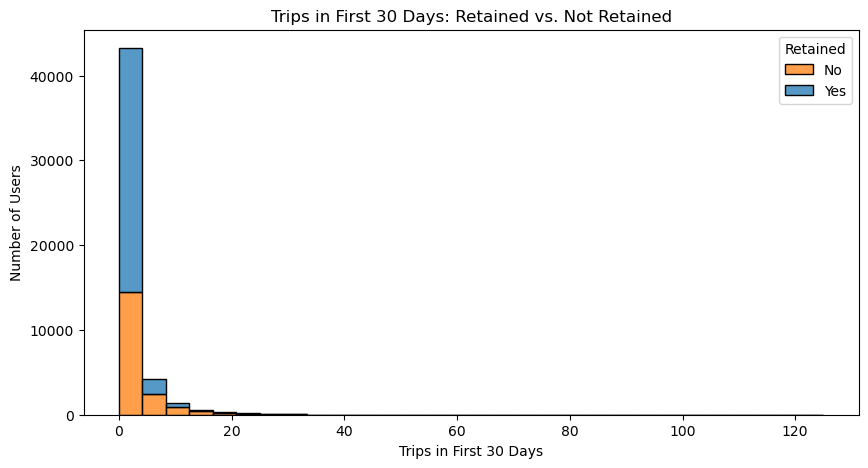

In [20]:
plt.figure(figsize=(10, 5))
sns.histplot(data=ultimate_df, x='trips_in_first_30_days', hue='active',bins=30, kde=False, multiple='stack')
plt.title('Trips in First 30 Days: Retained vs. Not Retained')
plt.xlabel('Trips in First 30 Days')
plt.ylabel('Number of Users')
plt.legend(title='Retained', labels=['No', 'Yes'])
plt.show()

This chart isn't entirely clear, as it's difficult to distinguish between non-users and active users who took 0 trips early on. However, it also shows that the majority of active users were not using the platform at all in the first 30 days, but remained. This system can show that using the platform in June is only one month to be considered active. Orange dominates in 5, 10, and 15 trips. This shows that even if a user took more trips within the first 30 days, they aren't necessarily likely to stick around.

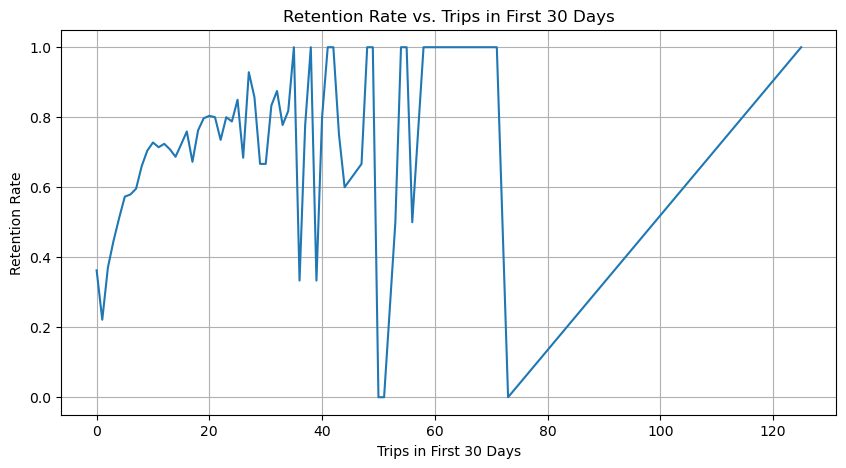

In [21]:
import numpy as np

# Group by trips and calculate average retention rate per trip count
retention_by_trips = ultimate_df.groupby('trips_in_first_30_days')['active'].mean()

plt.figure(figsize=(10,5))
retention_by_trips.plot()
plt.title('Retention Rate vs. Trips in First 30 Days')
plt.xlabel('Trips in First 30 Days')
plt.ylabel('Retention Rate')
plt.grid(True)
plt.show()


This new format looks a little better since 20-40 trips, retention hovers around 0.8-1, but after at 50 trips the platforms spikes downward could be due to bad customer service, and then its clear that after 65+ trips the chart rises to a higher retention rate.

<Axes: xlabel='active', ylabel='avg_dist'>

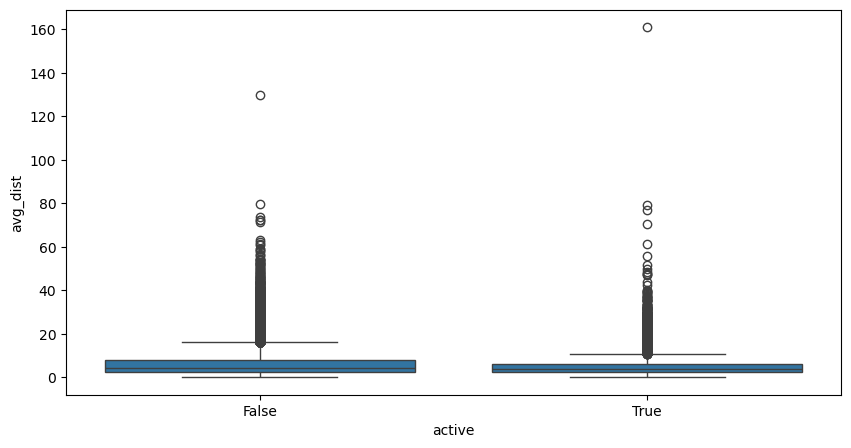

In [22]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='active', y='avg_dist', data=ultimate_df)

This shows that the median is a little noticeable difference higher for users who churned vs who did not, although overall this is a not a strong feature for indicating whether users will remain active or not in the platform.

#### Check whether users who recieves better drives by rating are likely to retain or not

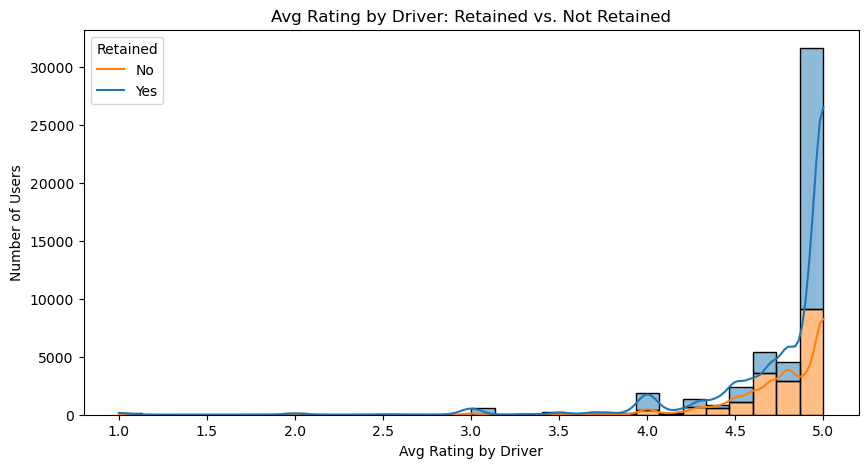

In [23]:
plt.figure(figsize=(10, 5))
sns.histplot(data=ultimate_df, x='avg_rating_by_driver', hue='active', bins=30, kde=True, multiple='stack')
plt.title('Avg Rating by Driver: Retained vs. Not Retained')
plt.xlabel('Avg Rating by Driver')
plt.ylabel('Number of Users')
plt.legend(title='Retained', labels=['No', 'Yes'])
plt.show()

This chart is much more clear and we can clearly see if that is a user gets a rating of 4.0+ they are likely to retain, it is strongly much more true at around 5.0 rating where blue dominates.

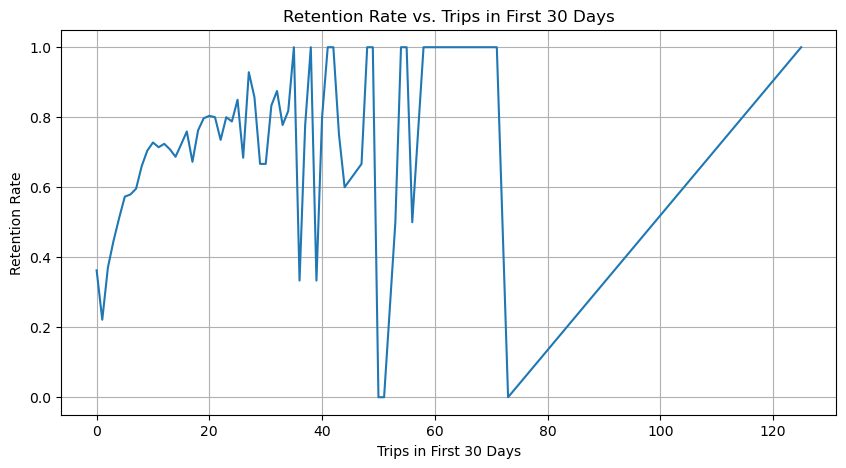

In [24]:
import numpy as np

# Group by trips and calculate average retention rate per trip count
retention_by_trips = ultimate_df.groupby('trips_in_first_30_days')['active'].mean()

plt.figure(figsize=(10,5))
retention_by_trips.plot()
plt.title('Retention Rate vs. Trips in First 30 Days')
plt.xlabel('Trips in First 30 Days')
plt.ylabel('Retention Rate')
plt.grid(True)
plt.show()


# Modelling

### Logistic Regression

Start with a classic simple prediction model for testing purposes

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression

In [33]:
target

0        1
1        0
2        0
3        1
4        0
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: active, Length: 50000, dtype: int32

In [ ]:
features = ultimate_df.drop(columns=['signup_date','last_trip_date','avg_dist','active'])  # active = target

# Convert True/False to 1/0
features = pd.get_dummies(features, drop_first=True)

# Handle missing values by imputing with the mean
features.fillna(features.mean(), inplace=True)
features = features.astype(int)

# Target variable
target = ultimate_df['active']
target = target.astype(int)
features.columns

Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct',
       'avg_rating_by_driver', 'city_King's Landing', 'city_Winterfell',
       'phone_iPhone'],
      dtype='object')

In [34]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, stratify=target)

model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall Score:", recall_score(y_test, y_pred))
print("Precision Score:", precision_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7110666666666666
Recall Score: 0.7154759794362702
Precision Score: 0.59660014781966
F1 Score: 0.6506529098823151

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.71      0.75      9359
           1       0.60      0.72      0.65      5641

    accuracy                           0.71     15000
   macro avg       0.70      0.71      0.70     15000
weighted avg       0.73      0.71      0.71     15000



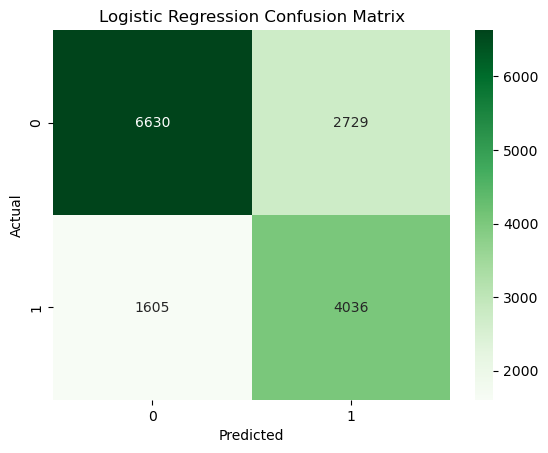

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

##### Overall the logistic regression was just a base method to test if we can get a good solid prediction, overall the prediction are ok since they meet the minimum threshold of at least 70%. However with a more complex model and since logistic regression is better for linear relationships, we can move on to the more complicated models with hyperparameter tuning.

# Random Forest 

#### Without hyerparameter tuning we want to see how a tree based model performs

In [52]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Random Forest:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Recall Score:", recall_score(y_test, y_pred_rf))
print("Precision Score:", precision_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest:
Accuracy: 0.7597333333333334
Recall Score: 0.6587484488565857
Precision Score: 0.6887859128822984
F1 Score: 0.6734324030445814

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81      9359
           1       0.69      0.66      0.67      5641

    accuracy                           0.76     15000
   macro avg       0.74      0.74      0.74     15000
weighted avg       0.76      0.76      0.76     15000



#### The accuracy improved but no sign of recall improving, in fact it dropped heavily so this model will definitely require hyperparameter tuning with cross-validation

In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [30, 50, 100],      # Number of trees in the forest
    'max_depth': [3, 5, 10, None],      # Maximum depth of each tree (None means nodes are expanded until all leaves are pure)
    'min_samples_split': [2, 5, 10],    # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],      # Minimum number of samples required to be at a leaf node
    'class_weight': ['balanced']        # Option to automatically adjust weights inversely proportional to class frequencies
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
print("Best parameters:", grid_search.best_params_)

print(f"\nAccuracy:, {accuracy_score(y_test, y_pred_best):.2f}")
print(f"Recall:, {recall_score(y_test, y_pred_best):.2f}")
print(f"Precision:, {precision_score(y_test, y_pred_best):.2f}")
print(f"F1 Score:, {f1_score(y_test, y_pred_best):.2f}")
print("\nClassification Report:", classification_report(y_test, y_pred_best))

Best parameters: {'class_weight': 'balanced', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Accuracy:, 0.74
Recall:, 0.75
Precision:, 0.63
F1 Score:, 0.68

Classification Report:               precision    recall  f1-score   support

           0       0.83      0.73      0.78      9359
           1       0.63      0.75      0.68      5641

    accuracy                           0.74     15000
   macro avg       0.73      0.74      0.73     15000
weighted avg       0.75      0.74      0.74     15000



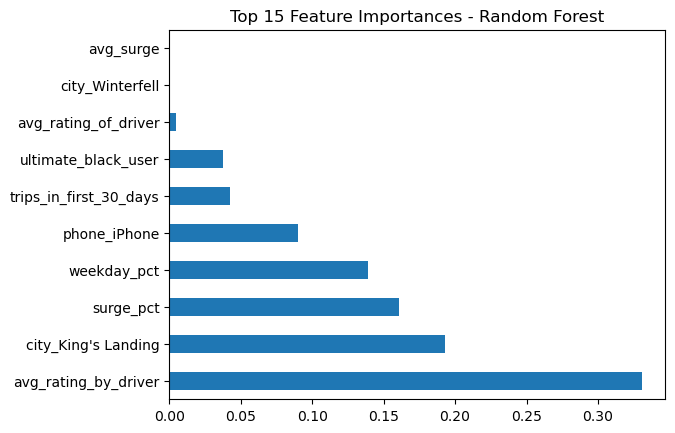

In [59]:
import matplotlib.pyplot as plt
import pandas as pd

feat_imp = pd.Series(best_rf.feature_importances_, index=features.columns)
feat_imp.nlargest(15).plot(kind='barh')
plt.title("Top 15 Feature Importances - Random Forest")
plt.show()


In [70]:

features2 = pd.get_dummies(features, drop_first=True)
features2.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_rating_by_driver,city_King's Landing,city_Winterfell,phone_iPhone
0,4,4,1,15,1,46,5,1,0,1
1,0,5,1,0,0,50,5,0,0,0
2,3,4,1,0,0,100,5,0,0,1
3,9,4,1,20,1,80,4,1,0,1
4,14,4,1,11,0,82,4,0,1,0


In [83]:
# Convert True/False to 1/0
features2 = pd.get_dummies(features, drop_first=True)
top_features = [
    'avg_rating_by_driver',
    'city_King\'s Landing',
    'surge_pct',
    'weekday_pct',
    'phone_iPhone',
    'trips_in_first_30_days',
    'ultimate_black_user',
    'avg_rating_of_driver'
]
features2 = features2[top_features]
# Handle missing values by imputing with the mean
features2.fillna(features.mean(), inplace=True)
features2 = features.astype(int)

# Target variable
target2 = ultimate_df['active']
target2 = target.astype(int)
features2.columns

Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct',
       'avg_rating_by_driver', 'city_King's Landing', 'city_Winterfell',
       'phone_iPhone'],
      dtype='object')

In [84]:
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(
    features2, target2, test_size=0.3, random_state=42, stratify=target2)

param_grid = {
    'n_estimators': [50],           # Number of trees in the forest
    'max_depth': [3],               # Maximum depth of each tree (None means nodes are expanded until all leaves are pure)
    'min_samples_split': [2],       # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1],        # Minimum number of samples required to be at a leaf node
    'class_weight': ['balanced']    # Option to automatically adjust weights inversely proportional to class frequencies
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_search.fit(X_train_reduced, y_train_reduced)

y_pred_best2 = best_rf.predict(X_test_reduced)
print("Best parameters:", grid_search.best_params_)

print(f"\nAccuracy:, {accuracy_score(y_test_reduced, y_pred_best2):.2f}")
print(f"Recall:, {recall_score(y_test_reduced, y_pred_best2):.2f}")
print(f"Precision:, {precision_score(y_test_reduced, y_pred_best2):.2f}")
print(f"F1 Score:, {f1_score(y_test_reduced, y_pred_best2):.2f}")
print("\nClassification Report:", classification_report(y_test_reduced, y_pred_best2))

Best parameters: {'class_weight': 'balanced', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Accuracy:, 0.74
Recall:, 0.75
Precision:, 0.63
F1 Score:, 0.68

Classification Report:               precision    recall  f1-score   support

           0       0.83      0.73      0.78      9359
           1       0.63      0.75      0.68      5641

    accuracy                           0.74     15000
   macro avg       0.73      0.74      0.73     15000
weighted avg       0.75      0.74      0.74     15000



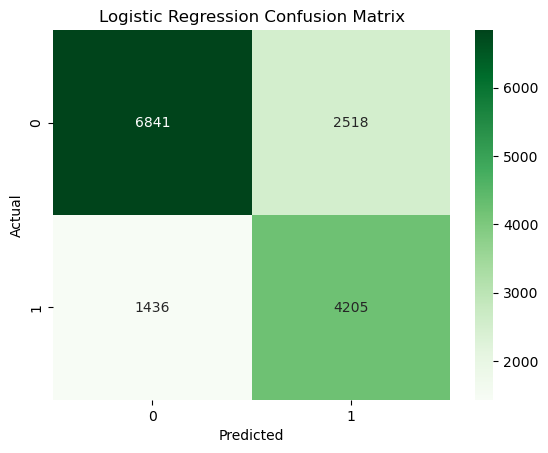

In [85]:
cm_rf = confusion_matrix(y_test_reduced, y_pred_best2)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Random Forest Summary

Using the top 8 features yields the same performance as the original model with 10 features, making it a more efficient and interpretable option. This also helps reduce potential multicollinearity. Overall, Random Forest significantly outperformed Logistic Regression. With hyperparameter tuning, we reduced the max depth to 3 to limit overfitting and achieved a stronger model, resulting in 74% accuracy and 75% recall.

# XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report

# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [100],
    'max_depth': [5],
    'learning_rate': [0.1],   # you can try [0.01, 0.1, 0.2] if you want to tune further
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'scale_pos_weight': [0, 1],  # set to 1 unless class imbalance is high
    'use_label_encoder': [False]
}

# Initialize model
xgb_clf = XGBClassifier(eval_metric='logloss')

# GridSearch
grid_search_xgb = GridSearchCV(xgb_clf, param_grid_xgb, scoring='recall', cv=5, n_jobs=-1)
grid_search_xgb.fit(X_train_reduced, y_train_reduced)

# Predictions
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_reduced)

y_proba_xgb = best_xgb.predict_proba(X_test_reduced)[:, 1]

threshold = 0.34
y_pred_thresh = (y_proba_xgb >= threshold).astype(int)

# Evaluate at new threshold
print(f"\nThreshold: {threshold}")

print(f"\nAccuracy: {accuracy_score(y_test_reduced, y_pred_thresh):.2f}")
print(f"Recall: {recall_score(y_test_reduced, y_pred_thresh):.2f}")
print(f"Precision: {precision_score(y_test_reduced, y_pred_thresh):.2f}")
print(f"F1 Score: {f1_score(y_test_reduced, y_pred_thresh):.2f}")
print("\nClassification Report:\n", classification_report(y_test_reduced, y_pred_thresh))


Threshold: 0.34

Accuracy: 0.77
Recall: 0.78
Precision: 0.67
F1 Score: 0.72

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.77      0.81      9359
           1       0.67      0.78      0.72      5641

    accuracy                           0.77     15000
   macro avg       0.76      0.77      0.76     15000
weighted avg       0.78      0.77      0.77     15000



c:\Users\soka\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:40:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


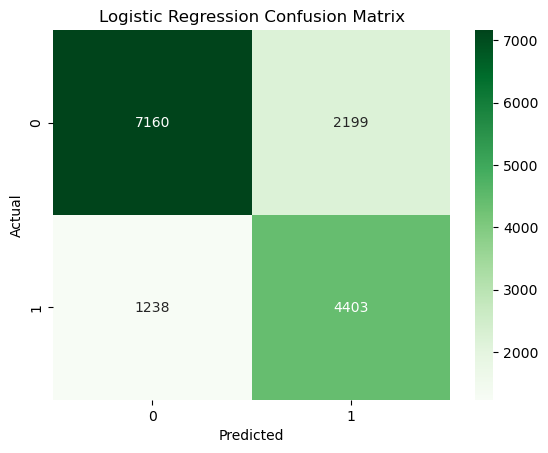

In [108]:
cm_rf = confusion_matrix(y_test_reduced, y_pred_thresh)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

#### XGBoost Summary

This model, even without threshold tuning, performed the best overall compared to Logistic Regression and Random Forest. It achieved the highest scores across all metrics — accuracy (77%), precision (67%), recall (78%), and F1 score (72%). 

The improvement in recall is especially important since our goal is to correctly identify as many actual positives as possible. The precision also increased compared to previous models, which shows a better balance between catching positives and avoiding false alarms.

This trade-off between precision and recall is common when tuning classification models, especially with imbalanced data. In this case, XGBoost finds the right balance and gives us the best performance, making it the most effective model out of the three.

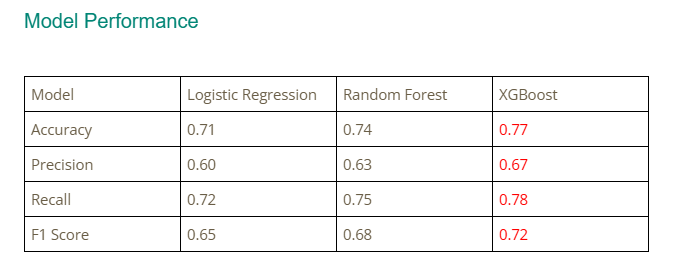

Ultimate can use the retention model to score every rider on their likelihood to churn and automatically trigger targeted interventions like ride credits or high rated driver matches for those that are most likely to churn. Using the model’s strongest predictors such as early trip frequency and driver ratings which can allow the company to invest in quality services. By focusing resources on the small subset of users most likely to leave, Ultimate can improve long-term retention efficiently.